In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import re

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

2025-08-03 17:45:51.134448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754243151.318386      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754243151.371582      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
image_path = "/kaggle/input/obss-intern-competition-2025/train/train"
# test_image = "/kaggle/input/obss-intern-competition-2025/test/test"


data = pd.read_csv("/kaggle/input/obss-intern-competition-2025/train.csv")
# test_data = pd.read_csv("/kaggle/input/obss-intern-competition-2025/test.csv")


In [3]:
data["caption"][1]

'Colorful postcard featuring "Greetings from Cherry Grove Beach, S.C." with images of beach scenes and vibrant lettering.'

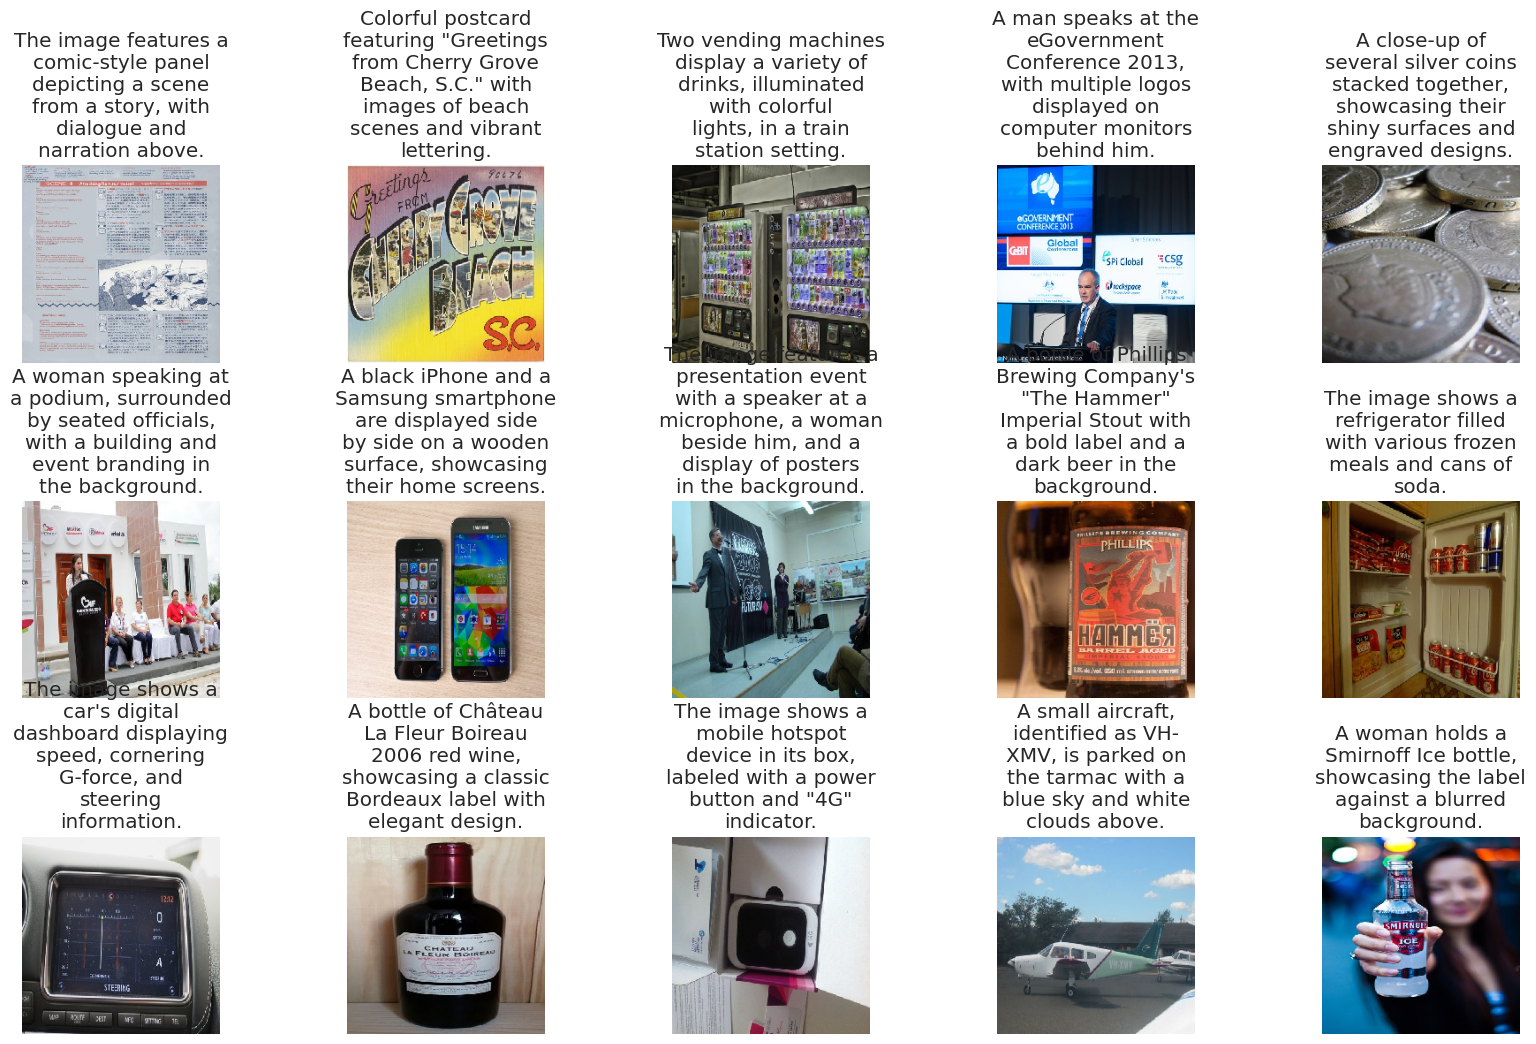

In [4]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode="rgb",target_size = (img_size,img_size))
    img = img_to_array(img)
    img = img/255
    return img

def display_image(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20,20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5,5,n)
        plt.subplots_adjust(hspace=0.7,wspace=0.3)
        image = readImage(f"/kaggle/input/obss-intern-competition-2025/train/train/{temp_df.image_id[i]}.jpg")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

display_image(data.head(15))

In [5]:
def text_processing(data):
    data["caption"] = data["caption"].apply(lambda x : re.sub(r'"[^"]*"', '', x))
    data["caption"] = data["caption"].apply(lambda x : x.lower())
    data['caption'] = data['caption'].apply(lambda x: re.sub(r"\s+", " ", x))
    data["caption"] = data["caption"].apply(lambda x: re.sub(r"[^\w\s]", "", x))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    
    data["caption"] = "startseq "+ data["caption"] + " endseq"
    return data

data = text_processing(data)
captions = data["caption"].tolist()
captions[:10]

['startseq the image features comicstyle panel depicting scene from story with dialogue and narration above endseq',
 'startseq colorful postcard featuring with images of beach scenes and vibrant lettering endseq',
 'startseq two vending machines display variety of drinks illuminated with colorful lights in train station setting endseq',
 'startseq man speaks at the egovernment conference 2013 with multiple logos displayed on computer monitors behind him endseq',
 'startseq closeup of several silver coins stacked together showcasing their shiny surfaces and engraved designs endseq',
 'startseq woman speaking at podium surrounded by seated officials with building and event branding in the background endseq',
 'startseq black iphone and samsung smartphone are displayed side by side on wooden surface showcasing their home screens endseq',
 'startseq the image features presentation event with speaker at microphone woman beside him and display of posters in the background endseq',
 'startse

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index)+1
max_length = max(len(caption.split()) for caption in captions)

images = data["image_id"].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train= data[data["image_id"].isin(train_images)]
test=data[data["image_id"].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 29, 913, 9, 5, 409, 8, 507, 1198, 3, 78, 580, 2]

In [7]:
model = DenseNet201()

fe = Model(inputs = model.input, outputs = model.layers[-2].output)

img_size =224
features={}

for image in tqdm(data["image_id"].unique().tolist()):
    img = load_img(os.path.join(image_path,str(image) + ".jpg"),target_size = (img_size,img_size))
    img = img_to_array(img)
    img=img/225
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img,verbose=0)
    features[image] = feature

I0000 00:00:1754243201.957952      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


  0%|          | 0/21367 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1754243216.599962      99 service.cc:148] XLA service 0x7edbf00ddda0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754243216.600947      99 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1754243218.643339      99 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1754243230.892269      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 21367/21367 [38:58<00:00,  9.14it/s] 


In [8]:
class CustomDataGenerator(Sequence):
    def __init__(self,df,X_col,y_col,batch_size,directory,tokenizer,vocab_size,max_length,features,shuffle=True):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.directory = directory
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)


    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):
        batch = self.df.iloc[index * self.batch_size: (index+1) * self.batch_size,:]
        X1,X2, y = self.__get_data(batch)
        return (X1,X2),y


    def __get_data(self,batch):
        X1, X2, y = list() , list() , list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image,self.y_col].tolist()

            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq,out_seq = seq[:i],seq[i]
                    in_seq = pad_sequences([in_seq],maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq],num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)


        X1,X2,y = np.array(X1), np.array(X2), np.array(y)
        return X1,X2,y


train_generator = CustomDataGenerator(df=train,X_col="image_id",y_col="caption",batch_size=64,directory=image_path,
                                     tokenizer = tokenizer,vocab_size=vocab_size,max_length=max_length,features = features)

validation_generator = CustomDataGenerator(df=test,X_col="image_id",y_col="caption",batch_size=64,directory=image_path,
                                     tokenizer = tokenizer,vocab_size=vocab_size,max_length=max_length,features = features)

In [9]:
from tensorflow.keras.utils import plot_model

input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(300,activation="relu")(input1)
img_features_reshaped = Reshape((1,300),input_shape=(300,))(img_features)

embedding_index = {}
with open("/kaggle/input/glove6b300dtxt/glove.6B.300d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs


embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector



sentence_features = Embedding(input_dim=vocab_size,
                               output_dim=embedding_dim,
                               weights=[embedding_matrix],
                               input_length=max_length,
                               trainable=False)(input2)





merged = concatenate([img_features_reshaped,sentence_features],axis=1)

sentence_features = LSTM(300, dropout=0.5, recurrent_dropout=0.3)(merged)


x = Dropout(0.5)(sentence_features)
x = add([x,img_features])
x = Dense(128,activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size,activation="softmax")(x)

caption_model = Model(inputs=[input1,input2],outputs=output)
caption_model.compile(loss="categorical_crossentropy",optimizer=Adam(learning_rate=0.001))

from tensorflow.keras.callbacks import ModelCheckpoint

#define the model checkpoint
model_name = "model.keras"
checkpoint = ModelCheckpoint(
    model_name,
    monitor = "val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

earlystopping = EarlyStopping (monitor = "val_loss",
    min_delta = 0,
    patience =5,
    verbose = 1,
    restore_best_weights=True
)

learning_rate_reduction = ReduceLROnPlateau(monitor = "val_loss",
    patience=3,
    verbose=1,
    facotr=0.2,
    min_lr =0.00000001
)

history = caption_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint,earlystopping,learning_rate_reduction]
)

Epoch 1/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 6.8785
Epoch 1: val_loss improved from inf to 5.56091, saving model to model.keras
283/283 ━━━━━━━━━━━━━━━━━━━━ 99s 324ms/step - loss: 6.8765 - val_loss: 5.5609 - learning_rate: 0.0010
Epoch 2/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 5.5812
Epoch 2: val_loss improved from 5.56091 to 5.10381, saving model to model.keras
283/283 ━━━━━━━━━━━━━━━━━━━━ 91s 323ms/step - loss: 5.5809 - val_loss: 5.1038 - learning_rate: 0.0010
Epoch 3/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 5.1705
Epoch 3: val_loss improved from 5.10381 to 4.85085, saving model to model.keras
283/283 ━━━━━━━━━━━━━━━━━━━━ 91s 321ms/step - loss: 5.1703 - val_loss: 4.8509 - learning_rate: 0.0010
Epoch 4/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 4.9208
Epoch 4: val_loss improved from 4.85085 to 4.69445, saving model to model.keras
283/283 ━━━━━━━━━━━━━━━━━━━━ 92s 323ms/step - loss: 4.9207 - val_loss: 4.6945 - learning_rate: 0.0010


In [10]:
import pickle

# Save the tokenizer
with open("tokenizer_obss.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save the feature extractor model
fe.save("feature_extractor_obss.keras")

In [42]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle

# load save files
model_path = "model.keras"
tokenizer_path = "tokenizer_obss.pkl"
feature_extractor_path = "feature_extractor_obss.keras"


def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=31, img_size=224):
    # Load the trained models and tokenizer
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)

    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Preprocess the image
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)
    image_features = feature_extractor.predict(img, verbose=0)  # Extract image features
    
    # Generate the caption
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break
    caption = in_text.replace("startseq", "").replace("endseq", "").strip()
    return caption

In [45]:
import time
start = time.time()
image_path_test = "/kaggle/input/obss-intern-competition-2025/test/test/100007.jpg"
caption_display = generate_and_display_caption(image_path_test, model_path, tokenizer_path, feature_extractor_path)

print(caption_display)
end = time.time()  # Bitiş zamanı
print(f"Süre: {end - start:.2f} saniye")

x="a colorful poster featuring a colorful book titled a colorful character with a colorful character in a colorful background"

the image shows the airplane with large blue and white design with the number and the other
Süre: 24.41 saniye


In [24]:
import numpy as np

def beam_search_caption(model, tokenizer, photo, max_length=31, beam_width=3):
    sequences = [[list(), 0.0]]  # [sequence, score]

    for _ in range(max_length):
        all_candidates = []
        for seq, score in sequences:
            in_text = "startseq" + (" " + " ".join([tokenizer.index_word.get(i, '') for i in seq])) if seq else "startseq"
            sequence = tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence], maxlen=max_length)

            yhat = model.predict([photo, sequence], verbose=0)[0]
            
            # En olası beam_width kelimeyi al
            top_indices = np.argsort(yhat)[-beam_width:]

            for idx in top_indices:
                # Tekrar cezası uygula (kelime daha önce kullanılmışsa ceza ver)
                penalty = 1.5 if idx in seq else 1.0
                candidate = [seq + [idx], score - np.log(yhat[idx]) * penalty]
                all_candidates.append(candidate)

        # Beam Search için en iyi beam_width adayı seç
        ordered = sorted(all_candidates, key=lambda tup: tup[1])
        sequences = ordered[:beam_width]

       # Erken durdur: 'endseq' geldiğinde temizle ve return et
        for seq, _ in sequences:
            if tokenizer.index_word.get(seq[-1]) == 'endseq':
                words = [tokenizer.index_word.get(i, '') for i in seq if i not in [0]]
                return ' '.join([w for w in words if w not in ['endseq']])

    return ' '.join([tokenizer.index_word.get(i, '') for i in sequences[0][0] if i not in [0]])


In [22]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def beam_search_caption_v2(model, tokenizer, photo_feature, max_length=31, beam_width=5, alpha=0.7):
    sequences = [[list(), 0.0]]  # [sequence, score]

    for _ in range(max_length):
        all_candidates = []

        for seq, score in sequences:
            in_text = "startseq" + (" " + " ".join([tokenizer.index_word.get(i, '') for i in seq])) if seq else "startseq"
            sequence = tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence], maxlen=max_length)

            yhat = model.predict([photo_feature, sequence], verbose=0)[0]
            top_indices = np.argsort(yhat)[-beam_width:]

            for idx in top_indices:
                repetition_penalty = 1.2 if idx in seq else 1.0
                new_score = score - (np.log(yhat[idx]) / (len(seq) + 1)**alpha) * repetition_penalty
                candidate = [seq + [idx], new_score]
                all_candidates.append(candidate)

        ordered = sorted(all_candidates, key=lambda tup: tup[1])
        sequences = ordered[:beam_width]

        # Erken durdur: 'endseq' geldiğinde temizle ve return et
        for seq, _ in sequences:
            if tokenizer.index_word.get(seq[-1]) == 'endseq':
                words = [tokenizer.index_word.get(i, '') for i in seq if i not in [0]]
                return ' '.join([w for w in words if w not in ['endseq']])

    # Tüm döngü bittiyse endseq yoksa yine temizle
    words = [tokenizer.index_word.get(i, '') for i in sequences[0][0] if i not in [0]]
    return ' '.join([w for w in words if w not in ['endseq']])


In [15]:
caption_model = load_model("model.keras")
feature_extractor = load_model("feature_extractor_obss.keras")

with open("tokenizer_obss.pkl", "rb") as f:
    tokenizer = pickle.load(f)



In [41]:
image_path = "/kaggle/input/obss-intern-competition-2025/test/test/100007.jpg"

# 1. Görseli yükle ve feature çıkar
img = load_img(image_path, target_size=(224,224))
img = img_to_array(img) / 255.0
img = np.expand_dims(img, axis=0)

feature = feature_extractor.predict(img, verbose=0)  # shape: (1,1920)

# 2. Caption üret
caption = beam_search_caption_v2(caption_model, tokenizer,feature, max_length=31, beam_width=5)
print("Generated Caption:", caption)


Generated Caption: the image shows an airplane is parked on the runway surrounded by trees in the background


Generated Caption: the image shows an orange airplane is parked on the runway surrounded by greenery


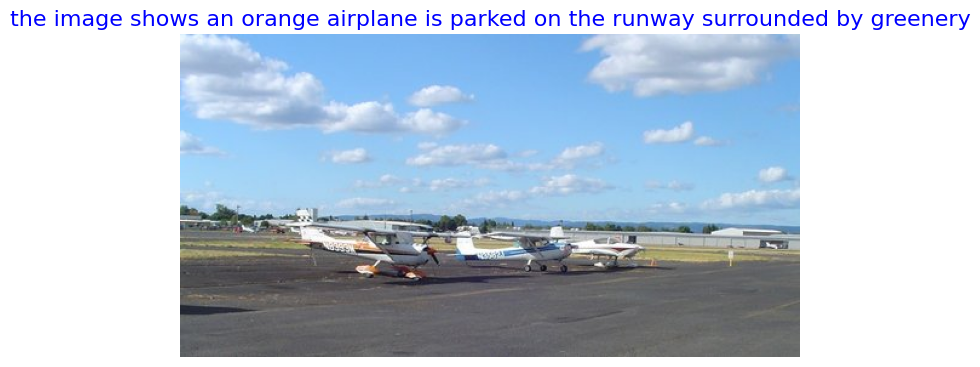

In [25]:
image_path = "/kaggle/input/obss-intern-competition-2025/test/test/100007.jpg"
img = load_img(image_path, target_size=(224, 224))
img = img_to_array(img) / 255.0
img = np.expand_dims(img, axis=0)

feature = feature_extractor.predict(img, verbose=0)  # Extract features

caption = beam_search_caption(caption_model, tokenizer,feature, max_length=31, beam_width=5)
print("Generated Caption:", caption)
img = load_img(image_path)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.title(caption, fontsize=16, color='blue')
plt.show()

In [26]:
test_data = pd.read_csv("/kaggle/input/obss-intern-competition-2025/test.csv")

In [36]:
for i in test_data.image_id:
    if i == 100005:
        break
    print(i)

100000
100001
100002
100003
100004


In [31]:
image_path_testing = "/kaggle/input/obss-intern-competition-2025/test/test"


In [61]:
images_number=[]
display_generator=[]
beam_v1_generator=[]
beam_v2_new=[]

for i in tqdm(range(100)):
    a = random.randint(1,len(test_data.image_id)+1)+ 100000
    images_number.append(a)
    image_path_testing_for= image_path_testing + f"/{a}.jpg"
    img = load_img(image_path_testing_for, target_size=(224, 224))
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    feature = feature_extractor.predict(img, verbose=0)  # Extract features

    caption_display = generate_and_display_caption(image_path_testing_for, model_path, tokenizer_path, feature_extractor_path)
    display_generator.append(caption_display)
    caption_beam_v1 = beam_search_caption(caption_model, tokenizer,feature, max_length=31, beam_width=5)
    beam_v1_generator.append(caption_beam_v1)
    caption_beam_v2 = beam_search_caption_v2(caption_model, tokenizer,feature, max_length=31, beam_width=5)
    beam_v2_new.append(caption_beam_v2)

100%|██████████| 100/100 [1:04:30<00:00, 38.71s/it]


In [72]:
df = pd.DataFrame({
    "image_id": images_number,
    "display_model": display_generator,
    "v1_beach": beam_v1_generator,
    "v2_beach": beam_v2_new
})

In [75]:
df.to_csv("/kaggle/working/image_caption.csv", index=False, encoding="utf-8")
df.to_excel("/kaggle/working/image_caption.xlsx", index=False, engine="openpyxl")


In [76]:
import pandas as pd
from openpyxl import load_workbook
from openpyxl.drawing.image import Image



# İlk olarak DataFrame'i Excel'e yaz
excel_path = "image_caption.xlsx"

# Excel dosyasını aç
wb = load_workbook(excel_path)
ws = wb.active

# Resimlerin bulunduğu klasör
image_folder = "/kaggle/input/obss-intern-competition-2025/test/test/"

# Her satıra ID'ye göre resmi ekle
for row in range(2, len(df) + 2):  # 2'den başlıyoruz çünkü 1. satır başlık
    image_id = ws[f"A{row}"].value  # ID sütunu
    img_path = f"{image_folder}{image_id}.jpg"  # Resim dosya yolu

    try:
        img = Image(img_path)
        img.width = 80  # Boyutu ayarla
        img.height = 80
        ws.add_image(img, f"E{row}")  # C sütununa ekle
    except FileNotFoundError:
        print(f"Resim bulunamadı: {img_path}")

# Kaydet
wb.save(excel_path)
print(f"Excel dosyası kaydedildi: {excel_path}")


Excel dosyası kaydedildi: image_caption.xlsx


In [73]:
df

,image_id,display_model,v1_beach,v2_beach
0,102206,the image shows the airplane with an orange an...,the image shows military airplane is parked on...,the image shows military airplane is parked on...
1,103720,the image shows television displaying the time...,the image shows computer monitor displaying th...,the image shows computer monitor displaying th...
2,100719,the image shows the back of the other and whit...,the image shows blue sports uniform with red a...,the image shows white sports uniform with red ...
3,103419,the image features book cover titled by the bo...,the image features book cover titled featuring...,the image features book cover titled featuring...
4,103617,the image features two women in sports uniform...,the image shows man in white sports uniform st...,the image shows two men in sports uniforms sta...
...,...,...,...,...
95,100742,glass of beer sits beside glass of golden beer...,glass of golden beer sits on wooden table show...,glass of golden beer sits beside glass filled ...
96,103400,the image shows the book titled by the text an...,the image shows an open book titled featuring ...,the image shows an open book titled featuring ...
97,100684,the image shows white mug with white text with...,the image shows an open mug with white design ...,the image shows an open mug with white mug wit...
98,102423,woman in sports uniform stands on the field we...,group of women in sports uniforms stand on the...,group of women in sports uniforms stand on the...
